# Bilateral Bargaining: Evaluation of the Experiments

In [2]:
import os
import sys
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
import re
import pandas as pd

# pylint: disable=wrong-import-position
sys.path.append(os.path.realpath('.'))
sys.path.append(os.path.join(os.path.expanduser('~'), 'projects/bnelearn'))

from bnelearn.util.metrics import ALIASES_LATEX
from scripts.utils import *

COLORS = (0/255.,150/255.,196/255.),(248/255.,118/255.,109/255.),(150/255.,120/255.,170/255.),(255/255.,215/255.,130/255.)

In [4]:
### EXP-1 BB 1/2-DA & VCG -----------------------------------------------------
path = '/home/kohring/bnelearn/experiments/debug/exp-1_experiment-v3'

path_kDA = path + '/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/1b1s/'
path_kDA += os.listdir(path_kDA)[0]
path_VCG = path + '/double_auction/single_item/vcg/uniform/symmetric/risk_1.0/1b1s/'
path_VCG += os.listdir(path_VCG)[0] 

exps = dict()
exps['$0.5$-DA'] = path_kDA + '/aggregate_log.csv'
exps['VCG'] = path_VCG + '/aggregate_log.csv'

with open(path_kDA + '/experiment_configurations.json') as json_file:
    running = json.load(json_file)['running']
    n_runs, n_epochs = running['n_runs'], running['n_epochs']

csv_to_tex(
    experiments = exps,
    name = os.curdir + '/exp-1_table.tex',
    metrics = ['eval_vs_bne/L_2', 'eval_vs_bne/epsilon_relative', 'eval/estimated_relative_ex_ante_util_loss'],
    caption = f"Mean and standard deviation over {'ten' if n_runs==10 else n_runs} runs of {int(n_epochs/1000)},000 iterations of the learning metrics for the average mechanism, i.e., the 1/2-double auction.",
    symmetric = False,
    label = 'tab:exp-1_table'
)

FileNotFoundError: [Errno 2] No such file or directory: '/home/kohring/bnelearn/experiments/debug/exp-1_experiment-v3/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/1b1s/'

In [5]:
def get_value_and_std_from_df_entry(df_entry: str) -> float:
    list_of_numbers = re.findall('\d+', df_entry)
    return float(list_of_numbers[0] + '.' + list_of_numbers[1]), float(list_of_numbers[2] + '.' + list_of_numbers[3])

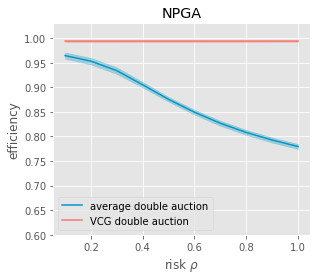

In [32]:
### EXP-2 risk experiments ----------------------------------------------------
path = '/home/pieroth/projects/bnelearn/experiments/bargaining_paper_results/exp-2_experiment/double_auction/single_item/'
exps = dict()
metric = 'metrics/pareto_efficiency_current_strategy'
fig = plt.figure(figsize=(4.5, 4))
plt.style.use('ggplot')

for j, (payment_rule, p_path) in enumerate(zip(['average double auction', 'VCG double auction'], ['k_price/0.5/uniform/symmetric', 'vcg/uniform/symmetric'])):  # 'vcg
    for risk_str in sorted(next(os.walk(path + p_path))[1]):
        exps[float(risk_str[5:])] = get_sub_path(path + p_path + '/' + risk_str, 2) + '/aggregate_log.csv'
        risks = np.array(list(exps.keys()))
        means = np.zeros_like(risks)
        stds = np.zeros_like(risks)
        for i, (risk, exp) in enumerate(exps.items()):
            df = single_exp_logs_to_df(path=exp, with_stddev=True, metrics=[metric])
            means[i], stds[i] = get_value_and_std_from_df_entry(df[metric][0])

    plt.plot(risks, means, label=payment_rule, color=COLORS[j])
    plt.fill_between(risks, means-stds, means+stds, color=COLORS[j], alpha=.3)
plt.xlabel('risk $\\rho$'); plt.ylabel('efficiency')
plt.ylim([0.6, 1.03])
plt.legend(loc='lower left');   
plt.tight_layout()
plt.savefig(os.curdir + '/exp-2_figure.pdf')
plt.show()

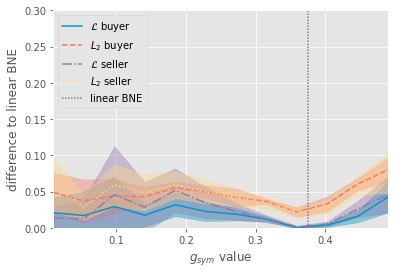

In [33]:
path = '/home/pieroth/projects/bnelearn/experiments/bargaining_paper_results/exp-3_experiment/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/1b1s/'
metrics_names = ["eval_vs_bne/epsilon_relative", "eval_vs_bne/L_2"]
metrics_names_latex = ["$\mathcal{L}^\text{BNE{1}}$", "$L_2^\text{BNE{1}}$"]
plot_metric_names_latex = ["$\mathcal{L}$", "$L_2$"]
bidders = ['buyer', 'seller']
exp_names = sorted(os.listdir(path))
metrics = np.zeros((2, 2, len(metrics_names), len(exp_names)))

g_05s = np.zeros(len(exp_names))
for i, exp_name in enumerate(exp_names):
    with open(path + exp_name + '/experiment_configurations.json') as json_file:
        g_05s[i] = float(json.load(json_file)['setting']['pretrain_transform'])
    df = single_exp_logs_to_df(path=path + exp_name + '/aggregate_log.csv',
                               with_stddev=True, metrics=metrics_names)
    # buyer
    for bidder_id in range(len(bidders)):
        for metric_id in range(len(metrics_names)):
            mean, std = get_value_and_std_from_df_entry(df[metrics_names_latex[metric_id]][bidder_id])
            metrics[bidder_id, 0, metric_id, i] = mean
            metrics[bidder_id, 1, metric_id, i] = std


metrics[metrics != metrics] = np.inf
colors = [[(0/255.,150/255.,196/255.), (248/255.,118/255.,109/255.)],
          [(150/255.,120/255.,170/255.), (255/255.,215/255.,130/255.)]]
linestyles = [["-", "--"], ["-.", ":"]]

plt.figure()
plt.style.use('ggplot')
for bidder_id, bidder in enumerate(bidders):
    for metric_name_id, metric_name in enumerate(plot_metric_names_latex):
        plt.plot(g_05s, metrics[bidder_id, 0, metric_name_id],
                 label=metric_name + ' ' + bidder, color=colors[bidder_id][metric_name_id],
                 linestyle=linestyles[bidder_id][metric_name_id])
        plt.fill_between(
            g_05s,
            metrics[bidder_id, 0, metric_name_id] - metrics[bidder_id, 1, metric_name_id],
            metrics[bidder_id, 0, metric_name_id] + metrics[bidder_id, 1, metric_name_id],
            alpha=0.4,
            color=colors[bidder_id][metric_name_id])
plt.plot([3./8., 3./8.], [0, 1], linestyle=(0, (1, 1)), color='grey', label=r'linear BNE')
plt.xlabel(r'$g_{sym}$ value')
plt.ylabel('difference to linear BNE')
plt.xlim([g_05s[0], g_05s[-1]]); plt.ylim([0, .3])
plt.legend(loc='upper left')
plt.savefig(os.curdir + '/exp-3_figure.pdf')
plt.show()

In [34]:
## EXP-3 custom pretraining experiments - Each pretrained BNE individually --------------------------------------
path = '/home/pieroth/projects/bnelearn/experiments/bargaining_paper_results/exp-3_experiment/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/1b1s/'
metrics_names = ['eval_vs_bne/L_2', 'eval_vs_bne/epsilon_relative', 'eval/estimated_relative_ex_ante_util_loss']
bne_ids = [1, 4]
metric_names_latex = ['pretrain_transform', 'bidder']
for bne_id in bne_ids:
    metric_names_latex.extend(["$\mathcal{L}^\text{BNE{%s}}$" % str(bne_id), "$L_2^\text{BNE{%s}}$" % bne_id])

exp_names = sorted(os.listdir(path))
experiments = {}
df_list = []
for i, exp_name in enumerate(exp_names):
    with open(path + exp_name + '/experiment_configurations.json') as json_file:
        g_05 = float(json.load(json_file)['setting']['pretrain_transform'])
        g_05 = "{:.2f}".format(g_05)
    df = single_exp_logs_to_df(path=path + exp_name + '/aggregate_log.csv',
                               with_stddev=True, metrics=metrics_names)
    df.insert(0, 'pretrain_transform', [g_05, None])
    df_list.append(df)
combined_df = pd.concat(df_list)
sliced_df = combined_df[metric_names_latex]

df_to_tex(sliced_df, name='exp-3_table_pretrain_transforms.tex',
        label='tab:exp-3_table_pretrain_transform',
        caption='Mean and standard deviation of experiments over ten runs' \
        + ' each for a different pretrained non-optimal Equilibrium.')

In [35]:
## EXP-3 custom pretraining experiments - Aggregated over all pretrained BNEs -------------------------------------
path_experiments = '/home/pieroth/projects/bnelearn/experiments/bargaining_paper_results/exp-3_experiment/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/1b1s/'
columns_to_drop = ['wall_time', 'run']
metric_names = ['eval_vs_bne/L_2_bne1', 'eval_vs_bne/epsilon_relative_bne1']
latex_col_names = ["$L_2$", "$\mathcal{L}$"]
aggregate_cols = ['tag', 'subrun']

row_values_to_filter = {
    'tag': metric_names,
    'epoch': [2000]}

# get all data (this may take some time)
df_dict = get_data_frames_from_multiple_experiments(path_experiments)
filtered_df_dict = {
    key: filter_full_results_df(value, row_values_to_filter, columns_to_drop) for key, value in df_dict.items()
}
concatenated_df = concatenate_dfs_from_dict(filtered_df_dict)
df = concatenated_df.groupby(
        aggregate_cols, as_index=False
    ).agg({'value': ['mean', 'std']})
df.columns = ['metric', 'bidder', 'mean', 'std']
df_mean_std = combine_mean_stddv_into_single_column(df, precision=3)
unstacked_df = df_unstack_values_by_tag_and_index(df_mean_std)
unstacked_df = unstacked_df[metric_names]  # reorder the columns to the given order
unstacked_df.rename({metric_name: latex_name for metric_name, latex_name in zip(metric_names, latex_col_names)}, inplace=True, axis=1)
# store as table
df_to_tex(unstacked_df, name='exp-3_table_all_runs_aggregated_epoch_2000.tex', print_index=True,
        print_index_names=True,
        label='tab:exp-3_table_pretrain_transform_aggregated',
        caption='Mean and standard deviation of experiments for the average mechanism, i.e., the 1/2-double auction, over twelve different' \
        + ' pretrained non-optimal Equilibria each run with ten different seeds.')


In [36]:
### EXP-4 Gaussian Prior 1/2-DA & VCG -----------------------------------------------------
path = '/home/pieroth/bnelearn/experiments/debug/exp-4_experiment-random_init'

path_kDA = path + '/double_auction/single_item/k_price/0.5/normal/symmetric/risk_1.0/1b1s/'
path_kDA += os.listdir(path_kDA)[0]
path_VCG = path + '/double_auction/single_item/vcg/normal/symmetric/risk_1.0/1b1s/'
path_VCG += os.listdir(path_VCG)[0] 

exps = dict()
exps['$0.5$-DA'] = path_kDA + '/aggregate_log.csv'
exps['VCG'] = path_VCG + '/aggregate_log.csv'

with open(path_kDA + '/experiment_configurations.json') as json_file:
    running = json.load(json_file)['running']
    n_runs, n_epochs = running['n_runs'], running['n_epochs']

csv_to_tex(
    experiments = exps,
    name = os.curdir + '/exp-4_table_random_init.tex',
    metrics = ['eval_vs_bne/L_2', 'eval_vs_bne/epsilon_relative', 'eval/estimated_relative_ex_ante_util_loss'],
    caption = f"Mean and standard deviation over {'ten' if n_runs==10 else n_runs} runs of {int(n_epochs/1000)},000 iterations of the learning metrics for the two most common mechanisms in the bilateral bargaining setup for a Gaussian prior with mean 15 and standard deviation 5. The strategies were initialized randomly.",
    symmetric = False,
    label = 'tab:exp-4_table'
)

FileNotFoundError: [Errno 2] No such file or directory: '/home/pieroth/bnelearn/experiments/debug/exp-4_experiment-random_init/double_auction/single_item/k_price/0.5/normal/symmetric/risk_1.0/1b1s/'

In [ ]:
### EXP-5: several buyers, 1 seller -----------------------------------------------------
path_to_experiments = '/home/pieroth/bnelearn/experiments/debug/'
experiment_names = [
    'exp-5_experiment', 'exp-5-2_experiment', 'exp-5-3_experiment'
]
auction_type = 'k_price'
experiment_name = 'exp_5_' + auction_type
save_name = '/' + experiment_name + '_table.tex'
label = 'tab:' + experiment_name
if auction_type == 'k_price':
    auction_path = '/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/'
    auction_latex_name = '$0.5$-DA'
elif auction_type == 'vcg':
    auction_path = '/double_auction/single_item/vcg/uniform/symmetric/risk_1.0/'
    auction_latex_name = 'VCG'
else:
    raise ValueError('No valid auction_type selected.')
exps = dict()
for k, experiment_name in enumerate(experiment_names):
    agent_dist_description = str(k+2) + 'b1s'
    full_experiment_path = path_to_experiments + experiment_name + auction_path + agent_dist_description + '/'
    full_experiment_path += os.listdir(full_experiment_path)[0]
    full_file_path = full_experiment_path + '/aggregate_log.csv'
    exps[agent_dist_description] = full_file_path

with open(full_experiment_path + '/experiment_configurations.json') as json_file:
    running = json.load(json_file)['running']
    n_runs, n_epochs = running['n_runs'], running['n_epochs']

csv_to_tex(
    experiments = exps,
    name = os.curdir + save_name,
    metrics = ['eval_vs_bne/L_2_bne2', 'eval_vs_bne/epsilon_relative_bne2', 'eval/estimated_relative_ex_ante_util_loss'],
    caption = f"Mean and standard deviation over {'ten' if n_runs==10 else n_runs} runs of {int(n_epochs/1000)},000 iterations of the learning metrics for the " + auction_latex_name + ' mechanism in a double auction setup with several buyers and one seller for a uniform prior.',
    symmetric = False,
    label = label
)

In [ ]:
### EXP-6: 1 buyer, several sellers -----------------------------------------------------
path_to_experiments = '/home/pieroth/bnelearn/experiments/debug/'
experiment_names = [
    'exp-6_experiment', 'exp-6-2_experiment', 'exp-6-3_experiment'
]
auction_type = 'k_price'
experiment_name = 'exp_6_' + auction_type
save_name = '/' + experiment_name + '_table.tex'
label = 'tab:' + experiment_name
if auction_type == 'k_price':
    auction_path = '/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/'
    auction_latex_name = '$0.5$-DA'
elif auction_type == 'vcg':
    auction_path = '/double_auction/single_item/vcg/uniform/symmetric/risk_1.0/'
    auction_latex_name = 'VCG'
else:
    raise ValueError('No valid auction_type selected.')
exps = dict()
for k, experiment_name in enumerate(experiment_names):
    agent_dist_description = '1b' + str(k+2) + 's'
    full_experiment_path = path_to_experiments + experiment_name + auction_path + agent_dist_description + '/'
    full_experiment_path += os.listdir(full_experiment_path)[0]
    full_file_path = full_experiment_path + '/aggregate_log.csv'
    exps[agent_dist_description] = full_file_path

with open(full_experiment_path + '/experiment_configurations.json') as json_file:
    running = json.load(json_file)['running']
    n_runs, n_epochs = running['n_runs'], running['n_epochs']

csv_to_tex(
    experiments = exps,
    name = os.curdir + save_name,
    metrics = ['eval_vs_bne/L_2_bne2', 'eval_vs_bne/epsilon_relative_bne2', 'eval/estimated_relative_ex_ante_util_loss'],
    caption = f"Mean and standard deviation over {'ten' if n_runs==10 else n_runs} runs of {int(n_epochs/1000)},000 iterations of the learning metrics for the " + auction_latex_name + ' mechanism in a double auction setup with one buyer and several sellers for a uniform prior.',
    symmetric = False,
    label = label
)

In [ ]:
### EXP-7: several buyers and sellers -----------------------------------------------------
path_to_experiments = '/home/pieroth/bnelearn/experiments/debug/'
experiment_names = [
    'exp-7_experiment', 'exp-7-2_experiment', 'exp-7-3_experiment'
]
auction_type = 'k_price'
experiment_name = 'exp_7_' + auction_type
save_name = '/' + experiment_name + '_table.tex'
label = 'tab:' + experiment_name
if auction_type == 'k_price':
    auction_path = '/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/'
    auction_latex_name = '$0.5$-DA'
elif auction_type == 'vcg':
    auction_path = '/double_auction/single_item/vcg/uniform/symmetric/risk_1.0/'
    auction_latex_name = 'VCG'
else:
    raise ValueError('No valid auction_type selected.')
exps = dict()
for k, experiment_name in enumerate(experiment_names):
    agent_dist_description = str(k+2) + 'b' + str(k +2 ) + 's'
    full_experiment_path = path_to_experiments + experiment_name + auction_path + agent_dist_description + '/'
    full_experiment_path += os.listdir(full_experiment_path)[0]
    full_file_path = full_experiment_path + '/aggregate_log.csv'
    exps[agent_dist_description] = full_file_path

with open(full_experiment_path + '/experiment_configurations.json') as json_file:
    running = json.load(json_file)['running']
    n_runs, n_epochs = running['n_runs'], running['n_epochs']

csv_to_tex(
    experiments = exps,
    name = os.curdir + save_name,
    metrics = ['eval_vs_bne/L_2_bne2', 'eval_vs_bne/epsilon_relative_bne2', 'eval/estimated_relative_ex_ante_util_loss'],
    caption = f"Mean and standard deviation over {'ten' if n_runs==10 else n_runs} runs of {int(n_epochs/1000)},000 iterations of the learning metrics for the " + auction_latex_name + ' mechanism in a double auction setup with several buyers and sellers for a uniform prior.',
    symmetric = False,
    label = label
)

In [ ]:
### EXP-8: three buyer, three seller -----------------------------------------------------
path = '/home/pieroth/bnelearn/experiments/debug/exp-8_experiment'
agent_description = 'three buyer and three seller'
experiment_name = path.split('/')[-1]
save_name = '/' + experiment_name + '_table.tex'
label = 'tab:' + experiment_name

path_kDA = path + '/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/3b3s/'
path_kDA += os.listdir(path_kDA)[0]
path_VCG = path + '/double_auction/single_item/vcg/uniform/symmetric/risk_1.0/3b3s/'
path_VCG += os.listdir(path_VCG)[0] 

exps = dict()
exps['$0.5$-DA'] = path_kDA + '/aggregate_log.csv'
exps['VCG'] = path_VCG + '/aggregate_log.csv'

with open(path_kDA + '/experiment_configurations.json') as json_file:
    running = json.load(json_file)['running']
    n_runs, n_epochs = running['n_runs'], running['n_epochs']

csv_to_tex(
    experiments = exps,
    name = os.curdir + save_name,
    metrics = ['eval/estimated_relative_ex_ante_util_loss'],
    caption = f"Mean and standard deviation over {'ten' if n_runs==10 else n_runs} runs of {int(n_epochs/1000)},000 iterations of the learning metrics for the two most common mechanisms in a double auction setup with " + agent_description + " for a uniform prior. The strategies for VCG were initialized randomly, the ones for the Average Auction were pretrained on the truthful strategy.",
    symmetric = False,
    label = label
)